# Модель для "Цифры"

## Общая информация о проекте

### Описание проекта

* Целью проекта является модель способная предсказать коэффициент восстановления золота из золотосодержащей руды.
* Имеются сырые данные с параметрами добычи и очистки.

### План

* Загрузка и предобработка данных:
    * Изучение файлов.
    * Проверка расчета эффективности обогощения.
    * Анализ признаков, недоступных в тестовой выборке.
    * Предобработка данных.
* Анализ данных:
    * Изменение концентрации металов на различных этапах.
    * Сравнение размеров гранул исходного сырья на обучающей и тестовой выборках.
    * Исследование суммарной концентрации металлов на разных стадиях.
* Построение модели:
    * Функция вычисления sMAPE.
    * Обучение разных моделей и оценка их качества кросс-валидацией.
* Общий вывод.

## Загрузка библиотек и инициализация констант

In [68]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

In [2]:
RANDOM_STATE = 12345

## Загрузка и предобработка данных

### Загрузка и общая информация о файлах

In [3]:
try:
    data_train = pd.read_csv('../../datasets/gold_industry_train.csv')
    data_test = pd.read_csv('../../datasets/gold_industry_test.csv')
    data_full = pd.read_csv('../../datasets/gold_industry_full.csv')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_train.csv')
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_test.csv')
    data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_industry_full.csv')

In [4]:
data_train.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


In [5]:
data_test.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
5,2017-12-09 19:59:59,5.848338,6.234198,4.468803,37.816555,547.515088,85.875864,8.040386,7.500718,1201.408796,...,22.977833,-499.910098,20.000113,-500.584093,18.003899,-500.326371,12.978611,-499.966502,19.988673,-500.742891
6,2017-12-09 20:59:59,6.172839,6.213598,4.458071,36.829223,518.363800,73.426294,7.641859,7.498470,1198.551240,...,22.964590,-500.083299,20.010567,-500.545746,18.040164,-498.936442,12.988702,-499.985412,20.014155,-499.443855
7,2017-12-09 21:59:59,5.743825,6.264367,4.428267,37.170131,500.494798,75.915232,7.230213,7.496599,1201.172468,...,23.010484,-500.498525,20.043525,-499.701442,17.991164,-500.324632,13.000809,-500.181711,20.001605,-500.229965
8,2017-12-09 22:59:59,5.558520,6.167472,4.370640,37.356892,540.990643,79.668503,7.089240,7.524634,1195.305111,...,22.979813,-500.451722,19.995022,-500.415107,18.057379,-499.238503,13.011922,-500.067255,20.002796,-504.347015
9,2017-12-09 23:59:59,5.473143,6.076597,4.274908,38.631317,492.146649,90.792119,7.367698,6.543369,1203.076302,...,23.050901,-501.185001,20.016755,-499.840744,17.991566,-500.303770,13.023215,-500.018271,20.015115,-515.537548


In [6]:
data_full.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [9]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


### Проверка вычисления эффективности обогащения

In [10]:
def recovery_calculation(c, f, t):
    return c * (f-t) / f / (c-t) * 100

In [11]:
data_train[data_train['rougher.output.recovery'] == recovery_calculation(
    data_train['rougher.output.concentrate_au'], 
    data_train['rougher.input.feed_au'], 
    data_train['rougher.output.tail_au']
)].count()

date                      6122
rougher.input.feed_au     6122
rougher.input.feed_ag     6122
rougher.input.feed_pb     6094
rougher.input.feed_sol    6084
                          ... 
final.output.recovery     6122
final.output.tail_au      6122
final.output.tail_ag      6121
final.output.tail_pb      6092
final.output.tail_sol     6119
Length: 87, dtype: int64

In [12]:
mae = (data_train['rougher.output.recovery'] - recovery_calculation(
    data_train['rougher.output.concentrate_au'], 
    data_train['rougher.input.feed_au'], 
    data_train['rougher.output.tail_au']
)).abs().sum() / data_train['rougher.output.recovery'].count()
mae

1.0851689485498649e-14

In [13]:
data_train['rougher.output.recovery'].describe()

count    14579.000000
mean        82.521200
std         15.797521
min          0.000000
25%         80.558542
50%         85.946497
75%         89.960375
max        100.000000
Name: rougher.output.recovery, dtype: float64

In [14]:
recovery_calculation(
    data_train['rougher.output.concentrate_au'], 
    data_train['rougher.input.feed_au'], 
    data_train['rougher.output.tail_au']
).describe()

count    14579.000000
mean        82.521200
std         15.797521
min         -0.000000
25%         80.558542
50%         85.946497
75%         89.960375
max        100.000000
dtype: float64

Эффективность обогащения после флотации на обучающей выборке посчитана в целом правильно, средняя абсолютная ошибка = 10 ** -14, что можно считать погрешностью.

### Признаки, недоступные в тестовой выборке

In [15]:
data_test.columns

Index(['date', 'rougher.input.feed_au', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_sol',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'prim

В тестовой выборке нет расчетных характеристик и параметров продукта на каждом этапе.

### Предобработка данных

#### Проверка на дубликаты

In [16]:
data_full.duplicated().sum()

0

In [17]:
data_test.duplicated().sum()

0

In [18]:
data_train.duplicated().sum()

0

#### Обработка пропусков

In [19]:
data_train.isnull().sum()*100/len(data_train)

date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.493861
rougher.input.feed_sol    0.528157
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.006859
final.output.tail_pb      0.514439
final.output.tail_sol     0.034296
Length: 87, dtype: float64

In [20]:
data_full.isnull().sum()*100/len(data_full)

date                      0.000000
rougher.input.feed_au     0.000000
rougher.input.feed_ag     0.000000
rougher.input.feed_pb     0.514430
rougher.input.feed_sol    0.509285
                            ...   
final.output.recovery     0.000000
final.output.tail_au      0.000000
final.output.tail_ag      0.005144
final.output.tail_pb      0.519574
final.output.tail_sol     0.030866
Length: 87, dtype: float64

In [21]:
data_test.isnull().sum()*100/len(data_test)

date                                          0.000000
rougher.input.feed_au                         0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.576132
rougher.input.feed_sol                        0.452675
rougher.input.feed_rate                       0.082305
rougher.input.feed_size                       0.905350
rougher.input.floatbank10_sulfate             0.061728
rougher.input.floatbank10_xanthate            0.020576
rougher.state.floatbank10_a_air               0.020576
rougher.state.floatbank10_a_level             0.020576
rougher.state.floatbank10_b_air               0.020576
rougher.state.floatbank10_b_level             0.020576
rougher.state.floatbank10_c_air               0.020576
rougher.state.floatbank10_c_level             0.020576
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               0.144033
rougher.st

In [22]:
data_test.dropna(axis=0)['date'].count() / data_test['date'].count()

0.9335390946502058

In [23]:
data_train.dropna(axis=0)['date'].count() / data_train['date'].count()

0.8462171616708964

In [24]:
data_full.dropna(axis=0)['date'].count() / data_full['date'].count()

0.8279232470806112

Пропусков в каждой колонке примерно до 1%, но если их удалять потеряются до 18% всей выборки. Заполним пропуски предыдущим значением в столбце, это не исказит распределение признаков. 

In [25]:
data_full = data_full.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data_train = data_train.fillna(method='ffill')
display(data_full.shape, data_test.shape, data_train.shape, data_full.isna().sum().sum(), data_test.isna().sum().sum(), data_train.isna().sum().sum())

C:\Users\klpkv\AppData\Local\Temp\ipykernel_21256\2042489833.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_full = data_full.fillna(method='ffill')
C:\Users\klpkv\AppData\Local\Temp\ipykernel_21256\2042489833.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_test = data_test.fillna(method='ffill')
C:\Users\klpkv\AppData\Local\Temp\ipykernel_21256\2042489833.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_train = data_train.fillna(method='ffill')


(19439, 87)

(4860, 53)

(14579, 87)

0

0

0

#### Изменение типов в колонках

In [26]:
data_full['date'] = pd.to_datetime(data_full['date'], format='%Y-%m-%d %H:%M:%S')
data_full['date']

0       2016-01-15 00:00:00
1       2016-01-15 01:00:00
2       2016-01-15 02:00:00
3       2016-01-15 03:00:00
4       2016-01-15 04:00:00
                ...        
19434   2018-08-18 06:59:59
19435   2018-08-18 07:59:59
19436   2018-08-18 08:59:59
19437   2018-08-18 09:59:59
19438   2018-08-18 10:59:59
Name: date, Length: 19439, dtype: datetime64[ns]

In [27]:
data_train['date'] = pd.to_datetime(data_train['date'], format='%Y-%m-%d %H:%M:%S')
data_train['date']

0       2016-01-15 00:00:00
1       2016-01-15 01:00:00
2       2016-01-15 02:00:00
3       2016-01-15 03:00:00
4       2016-01-15 04:00:00
                ...        
14574   2017-12-09 09:59:59
14575   2017-12-09 10:59:59
14576   2017-12-09 11:59:59
14577   2017-12-09 12:59:59
14578   2017-12-09 13:59:59
Name: date, Length: 14579, dtype: datetime64[ns]

In [28]:
data_test['date'] = pd.to_datetime(data_test['date'], format='%Y-%m-%d %H:%M:%S')
data_test['date']

0      2017-12-09 14:59:59
1      2017-12-09 15:59:59
2      2017-12-09 16:59:59
3      2017-12-09 17:59:59
4      2017-12-09 18:59:59
               ...        
4855   2018-08-18 06:59:59
4856   2018-08-18 07:59:59
4857   2018-08-18 08:59:59
4858   2018-08-18 09:59:59
4859   2018-08-18 10:59:59
Name: date, Length: 4860, dtype: datetime64[ns]

### Выводы по разделу

* Эффективность обогащения рассчитана правильно, MAE между расчетными значениями и значением признака = 10 ** -14, что можно считать погрешностью.
* В тестовой выборке нет расчетных характеристик и параметров продукта на каждом этапе.
* Дубликатов в данных нет.
* Пропущенные значения были заполнены предыдущим значение колонки.
* Во всех таблицах тип колонки date изменен на datetime.

## Анализ данных

### Изменение концентрации металлов на разных этапах.

#### Сравнение по среднему и медианам

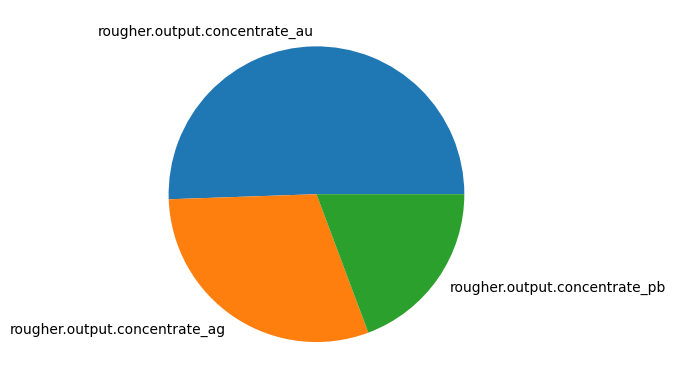

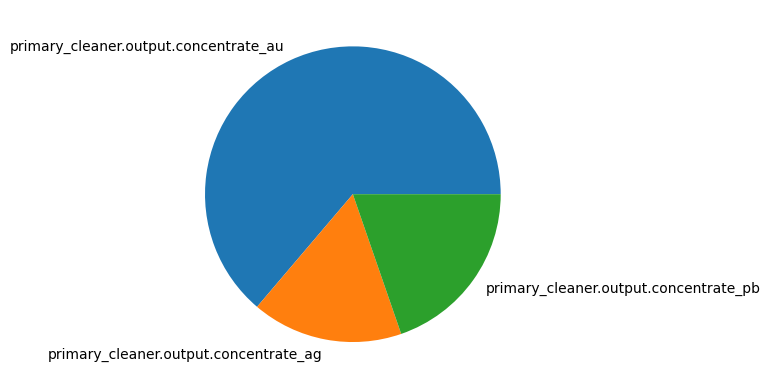

array([<AxesSubplot:>], dtype=object)

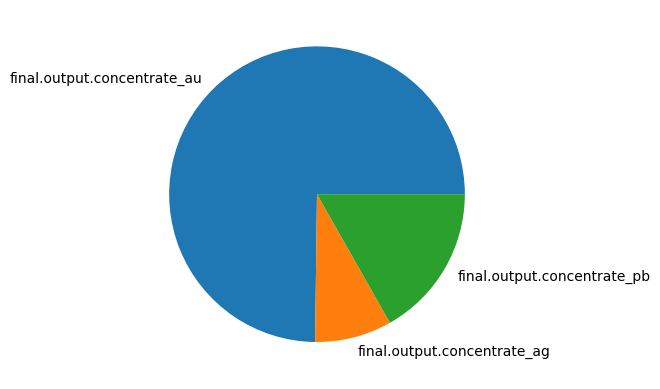

In [29]:
data_full[[
    'rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
]].median().plot(kind='pie', subplots=True)
plt.show()
data_full[[
    'primary_cleaner.output.concentrate_au', 
    'primary_cleaner.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_pb', 
]].median().plot(kind='pie', subplots=True)
plt.show()
data_full[[
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb'
]].median().plot(kind='pie', subplots=True)

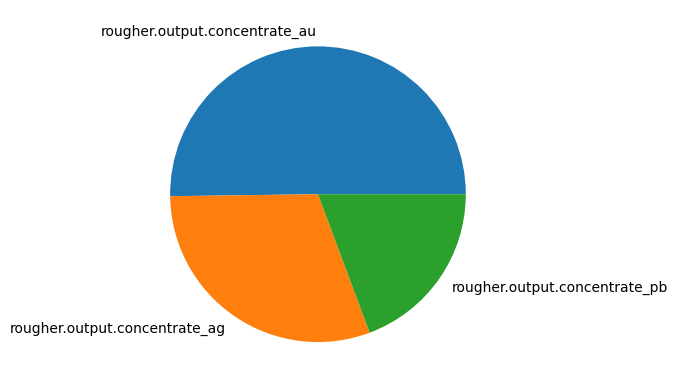

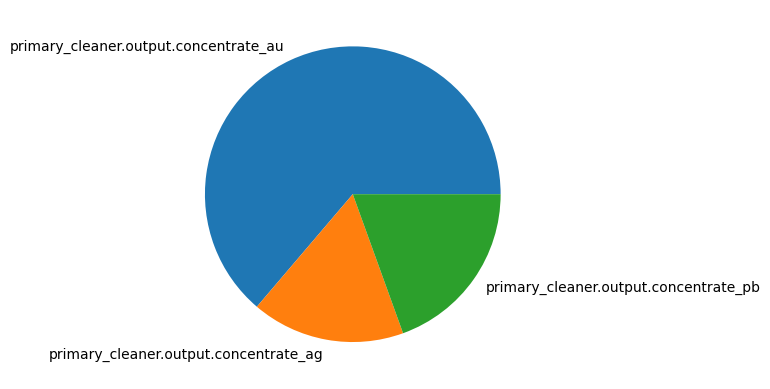

array([<AxesSubplot:>], dtype=object)

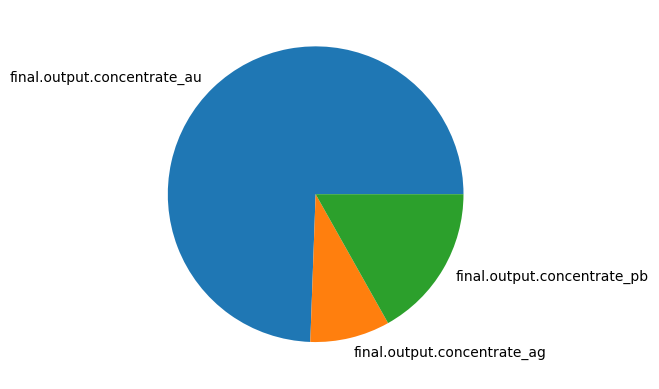

In [30]:
data_full[[
    'rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
]].mean().plot(kind='pie', subplots=True)
plt.show()
data_full[[
    'primary_cleaner.output.concentrate_au', 
    'primary_cleaner.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_pb', 
]].mean().plot(kind='pie', subplots=True)
plt.show()
data_full[[
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb'
]].mean().plot(kind='pie', subplots=True)

#### Сравнение гистограм

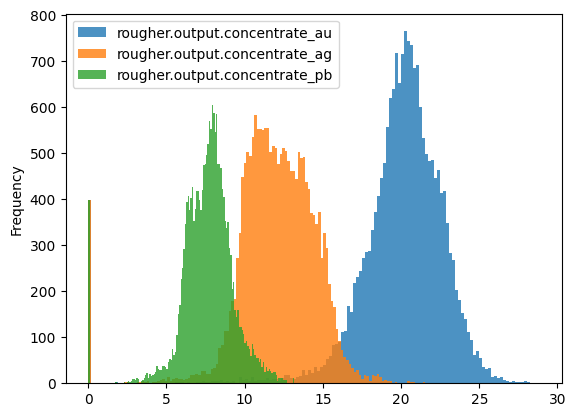

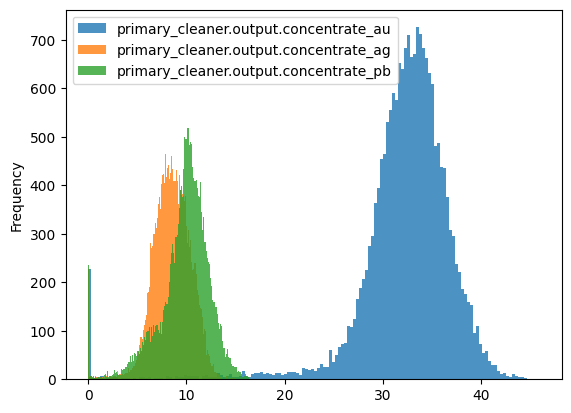

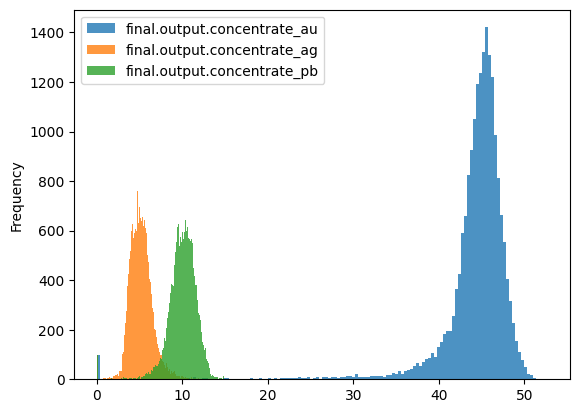

In [31]:
count = 1
for t in ['rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_au', 
    'primary_cleaner.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb']:
    data_full[t].plot(kind='hist', bins=150, alpha=0.8, legend=True, label=t)
    if count % 3 == 0:
        plt.show()
    count += 1

#### Сравнение диаграмм размаха

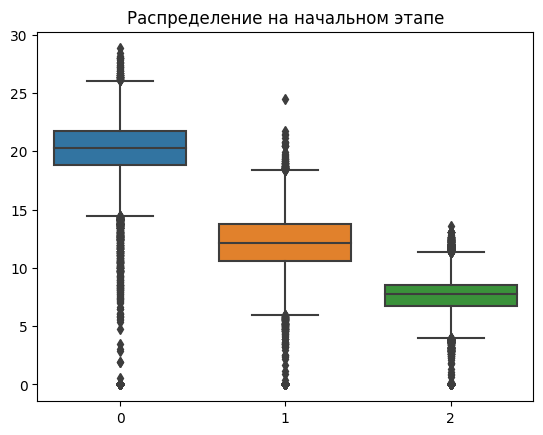

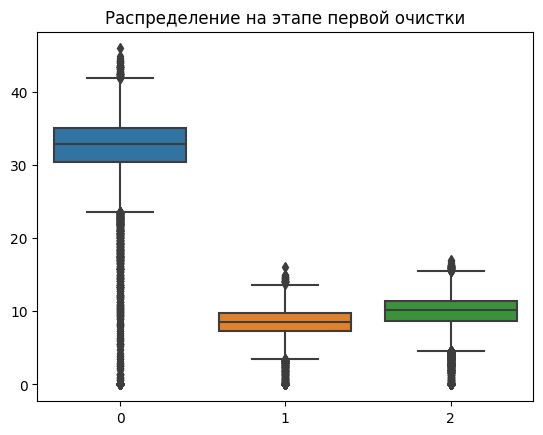

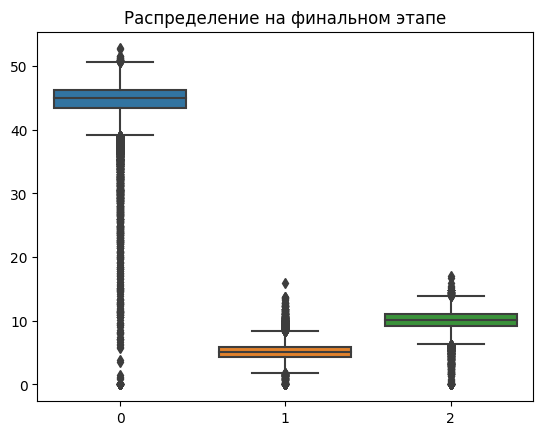

In [32]:
sns.boxplot(data=(data_full['rougher.output.concentrate_au'], data_full['rougher.output.concentrate_ag'], data_full['rougher.output.concentrate_pb']))\
    .set_title('Распределение на начальном этапе');
plt.show()
sns.boxplot(data=(data_full['primary_cleaner.output.concentrate_au'], data_full['primary_cleaner.output.concentrate_ag'], data_full['primary_cleaner.output.concentrate_pb']))\
    .set_title('Распределение на этапе первой очистки');
plt.show()
sns.boxplot(data=(data_full['final.output.concentrate_au'], data_full['final.output.concentrate_ag'], data_full['final.output.concentrate_pb']))\
    .set_title('Распределение на финальном этапе');
plt.show()

In [33]:
# Удаление нулей в концентрации на кадом этапе
data_full = data_full[(data_full['rougher.output.concentrate_au'] != 0.) & \
                (data_full['rougher.output.concentrate_ag'] != 0.) & \
                (data_full['rougher.output.concentrate_pb'] != 0.) & \
                (data_full['primary_cleaner.output.concentrate_au'] > 0.01) & \
                (data_full['primary_cleaner.output.concentrate_ag'] > 0.01) & \
                (data_full['primary_cleaner.output.concentrate_pb'] > 0.01) & \
                (data_full['final.output.concentrate_au'] != 0.) & \
                (data_full['final.output.concentrate_ag'] != 0.) & \
                (data_full['final.output.concentrate_pb'] != 0.)]
data_full.shape

(18724, 87)

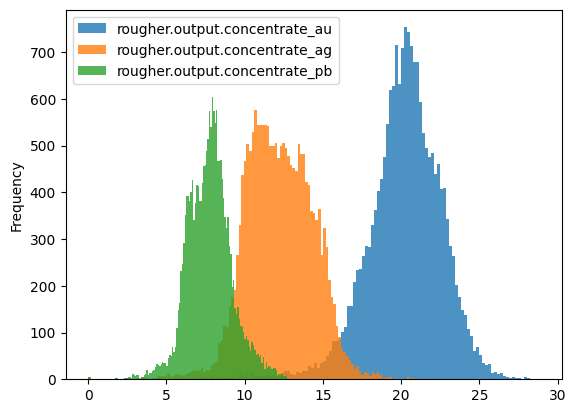

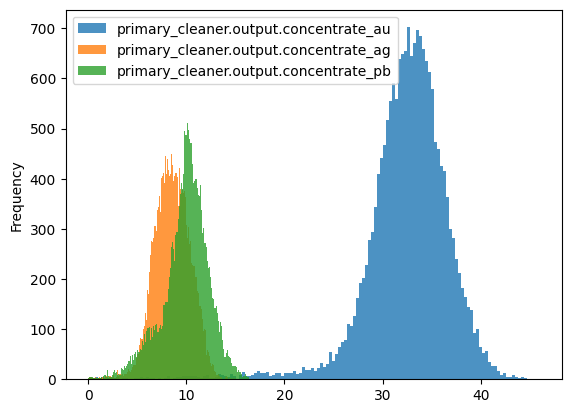

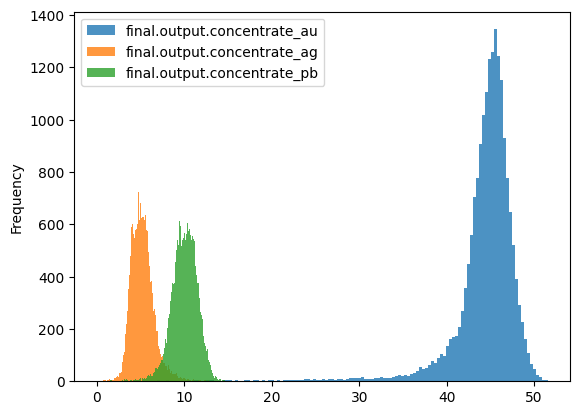

In [34]:
# Проверка после удаления выбросов
count = 1
for t in ['rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
    'primary_cleaner.output.concentrate_au', 
    'primary_cleaner.output.concentrate_ag', 
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_au', 
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb']:
    data_full[t].plot(kind='hist', bins=150, alpha=0.8, legend=True, label=t)
    if count % 3 == 0:
        plt.show()
    count += 1

In [35]:
data_full[(data_full['primary_cleaner.output.concentrate_au'] < 0.01) & \
        (data_full['primary_cleaner.output.concentrate_ag'] < 0.01) & \
        (data_full['primary_cleaner.output.concentrate_pb'] < 0.01)]

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol


На графиках видно что с каждым этапом концентрация золота и свинца увеличивается, а концентрация серебра уменьшается. Также видны выбросы в нуле по концентрациям на каждом этапе.

### Сравнение распределения гранул исходного сырья на обучающей и тестовой выборках

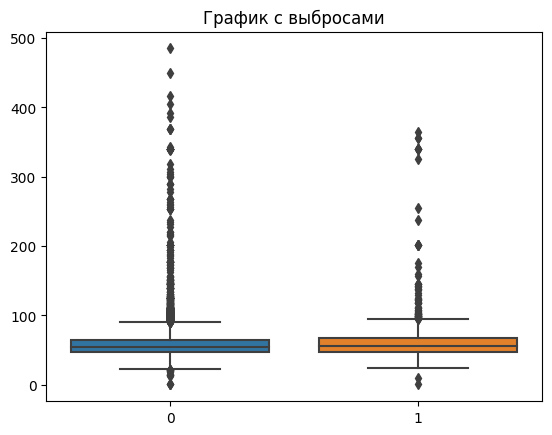

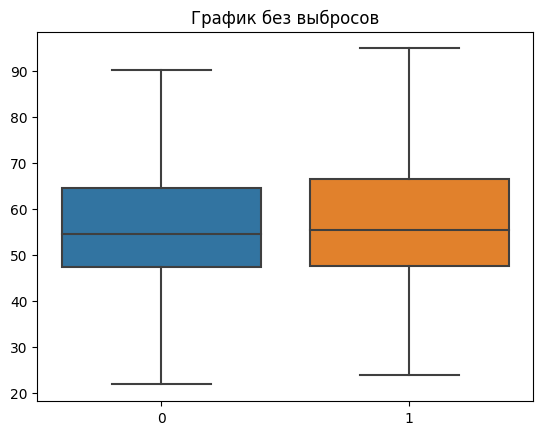

In [36]:
sns.boxplot(data=(data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size'])).set_title('График с выбросами');
plt.show()
sns.boxplot(data=(data_train['rougher.input.feed_size'], data_test['rougher.input.feed_size']), showfliers=False).set_title('График без выбросов');

In [37]:
display(data_train['rougher.input.feed_size'].describe())
data_test['rougher.input.feed_size'].describe()

count    14579.000000
mean        59.070865
std         22.903811
min          0.049194
25%         47.322462
50%         54.464259
75%         64.469177
max        484.967466
Name: rougher.input.feed_size, dtype: float64

count    4860.000000
mean       59.136150
std        19.512497
min         0.046369
25%        47.610795
50%        55.461058
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64

Распределения имеют некоторые различия: значения на тевтовой выборке немного больше чем на тренировочной и имеют большую дисперсию. 

### Исследование суммарной концентрации металлов на разных стадиях

In [38]:
def sum_rows(data: pd.DataFrame, rows_names: list, col: str):
    result = data[rows_names[-1]].copy()
    rows_names.pop()
    for row in rows_names:
        result += data[row]
    return pd.DataFrame(data=result.values, index=data.index, columns=[col])

In [39]:
rougher_sum_concentrat = sum_rows(data_full, [
    'rougher.output.concentrate_au', 
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb',
    ], 'rougher_sum_concentrat')

primary_cleaner_sum_concentrat = sum_rows(data_full, [
    'primary_cleaner.output.concentrate_au',
    'primary_cleaner.output.concentrate_ag',
    'primary_cleaner.output.concentrate_pb',
    ], 'primary_cleaner_sum_concentrat')

final_sum_concentrat = sum_rows(data_full, [
    'final.output.concentrate_au',
    'final.output.concentrate_ag',
    'final.output.concentrate_pb',
    ], 'final_sum_concentrat')

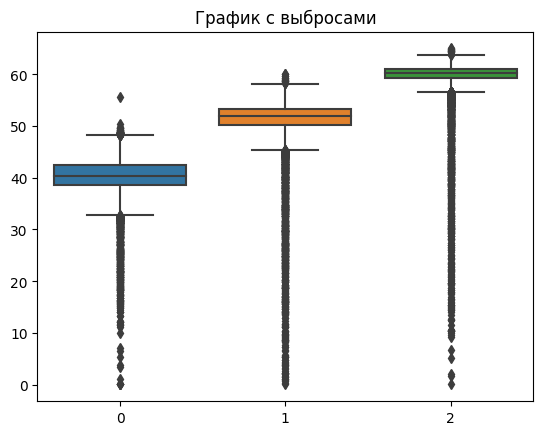

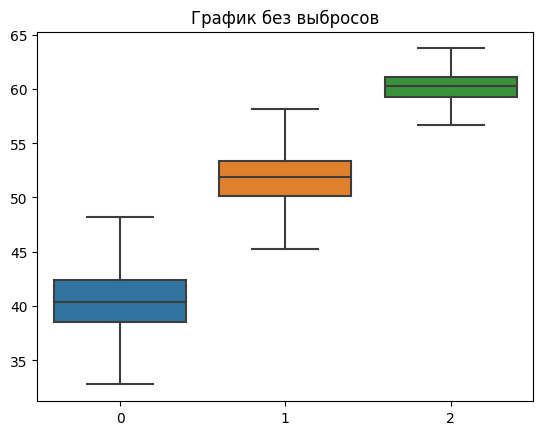

In [40]:
sns.boxplot(data=(rougher_sum_concentrat, primary_cleaner_sum_concentrat, final_sum_concentrat)).set_title('График с выбросами');
plt.show()
sns.boxplot(data=(rougher_sum_concentrat, primary_cleaner_sum_concentrat, final_sum_concentrat), showfliers=False).set_title('График без выбросов');

<AxesSubplot:ylabel='Frequency'>

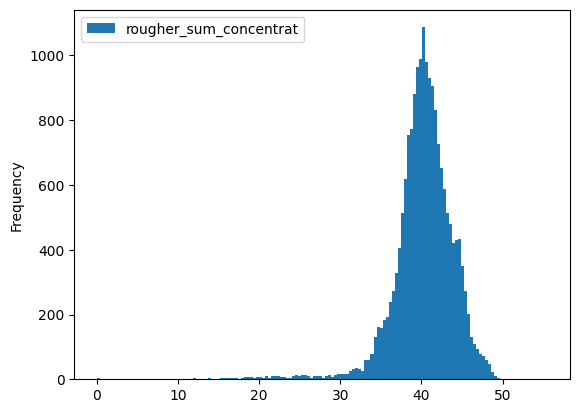

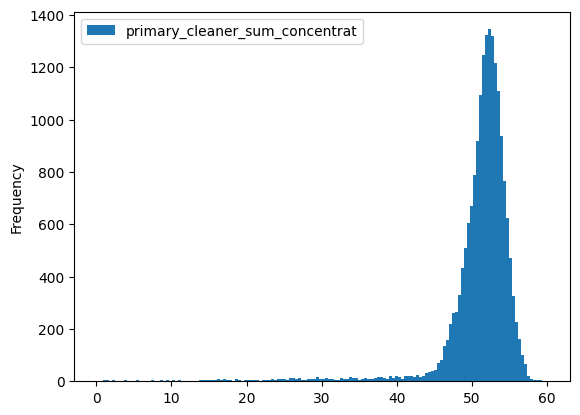

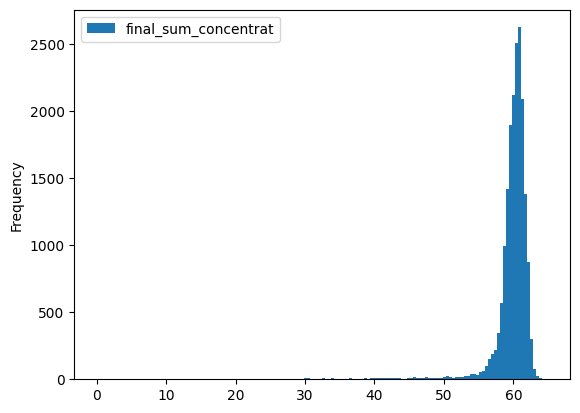

In [41]:
rougher_sum_concentrat.plot(kind='hist', bins=150)
primary_cleaner_sum_concentrat.plot(kind='hist', bins=150)
final_sum_concentrat.plot(kind='hist', bins=150)

На графиках видно, что с каждым этапом концентрация металлов увеличивается.

### Вывод по разделу

* Концентрация золота и свинца увеличивается от начального этапа к финальному, а кончентрация серебра уменьшается.
* Распределения размеров гранул исходного сырья на обучающей и тестовой выборках имеют некоторые различия: на тестовой выборке значения больше чем на обучающей и имеют большую дисперсию.
* Суммарная концентрация металлов увеличивается от начального этапа к финальному.
* Удалены выбросы.

## Постоение модели

### Функции для расчета sMAPE

In [42]:
def smape_calculation(target: pd.Series, prediction: pd.Series):
    return (target - prediction).abs() / ((target.abs() + prediction.abs()) / 2) / target.count() * 100

In [43]:
def final_smape(target: pd.Series, prediction: pd.Series):
    return 25 * smape_calculation(target['rougher.output.recovery'], prediction['rougher.output.recovery']) + \
        75 * smape_calculation(target['final.output.recovery'], prediction['final.output.recovery'])

In [102]:
my_score = make_scorer(final_smape, greater_is_better=False)

### Обучение моделей и выбор лучшей

In [105]:
# Класс для работы с моделями
class MultiModelLearning:
    def __init__(self, data: pd.DataFrame):
        self.model = None
        self.best_model = None
        self.data = data
        self.predict = None
        self.features = None
        self.target = None
        self.all_data_predictions = None
        self.hyperparameters = None
        self.best_score = None
        self.split_samples__()


    def split_samples__(self):
        try:
            self.features = self.data.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1, inplace=False)
            self.target = self.data.loc[:, ['rougher.output.recovery', 'final.output.recovery']]
        except Exception as e:

            display('Ошибка в разбиении выборки')

    # Подбор гиперпараметров для модели
    def select_hyperparameters__(self, param_dist):
        random_search = GridSearchCV(self.model, param_grid=param_dist, cv=5, scoring=my_score)
        random_search.fit(self.features, self.target)
        self.best_model = random_search.best_estimator_
        self.hyperparameters = random_search.best_params_
        self.best_score = random_search.best_score_

    # Обучение линейной регрессии
    def learn_linear_regression__(self): 
        try:
            self.model = LinearRegression()
            self.best_score = cross_val_score(self.model, self.features, self.target, cv=5, scoring=my_score)/5
        except Exception as e:
            display("При обучении модели линейной регрессии произошла непредвиденная ошибка!")
    
    # Обучение решающего дерева
    def learn_tree__(self):
        param_dist = {
            'max_depth': [i for i in range(1,15)]
        }
        try: 
            self.model = DecisionTreeRegressor()
            self.select_hyperparameters__(param_dist)
        except Exception as e:
            display(e)
            display("При обучении модели решающего дерева произошла непредвиденная ошибка!")

    def learn_random_forest__(self): 
        param_dist = {
            'n_estimators': [i for i in range(10,121,10)],
            'max_depth': [i for i in range(1,15)],
            'min_samples_leaf': [1, 2, 4]
        }
        try:
            self.model = RandomForestRegressor()
            self.select_hyperparameters__(param_dist)
        except Exception as e:
            display("При обучении модели случайного леса произошла непредвиденная ошибка!")

    def learn_ann__(self):
        param_dist = {
            'learning_rate_init': [.0001, .0005, .001, .005, .01],
        }
        try:
            self.model = MLPRegressor()
            self.select_hyperparameters__(param_dist)
        except Exception as e:
            display("При обучении модели нейронной сети произошла непредвиденная ошибка!")

    def learn_boosting__(self):
        param_dist = {
            'learning_rate_init': [.0001, .0005, .001, .005, .01, .05, .1],
            'n_estimators': [i for i in range(10,121,10)],
            'max_depth': [i for i in range(1, 8)],
        }
        try:
            self.model = GradientBoostingRegressor()
            self.select_hyperparameters__(param_dist)
        except Exception as e:
            display("При обучении модели градиентного бустинга произошла непредвиденная ошибка!")

    def learn_bagging__(self):
        param_dist = {
            'n_estimators': [i for i in range(1, 15)],
            'bootstrap': False
        }
        try:
            self.model = BaggingRegressor()
            self.select_hyperparameters__(param_dist)
        except Exception as e:
            display("При обучении модели бэггинга произошла непредвиденная ошибка!")

    def select_model(self, model_name):
        if model_name == 'linear_regressor':
            self.learn_linear_regression__()
        elif model_name == 'ann':
            self.learn_ann__()
        elif model_name == 'tree':
            self.learn_tree__()
        elif model_name == 'random_forest':
            self.learn_random_forest__()
        elif model_name == 'bagging':
            self.learn_bagging__()
        elif model_name == 'boosting':
            self.learn_boosting__()
        else:
            display("Было введено неверное имя модели")
    
    # Вывод и сохранение результатов
    # Запускать только после обучения модели
    def print_learn_result(self):
        try:
            display("sMAPE:", self.best_score)
            display("Оценка кросс-валидацией", cross_val_score(self.best_model, self.features, self.target, cv=10, scoring=my_score)/10)
        except Exception as e:
            display(e)
            display('Ошибка при печати результатов')

    def new_prediction(self, features):
        try:
            model_predictions = self.best_model.predict(features)
            return model_predictions
        except Exception as e:
            display("Неудалось получить результаты модели")

In [106]:
tree_model = MultiModelLearning(data_train)

In [107]:
tree_model.select_model('tree')

e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\klpkv\AppData\Local\Temp\ipykernel_21256\2620777382.py", line 2, in final_smape
    return 25 * smape_calculation(target['rougher.output.recovery'], prediction['rougher.output.recovery']) + \
IndexError: on

In [101]:
tree_model.print_learn_result()

'sMAPE:'

nan

e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "e:\programs\anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\klpkv\AppData\Local\Temp\ipykernel_21256\2620777382.py", line 2, in final_smape
    return 25 * smape_calculation(target['rougher.output.recovery'], prediction['rougher.output.recovery']) + \
IndexError: only integers, slices (`:`)

'Оценка кросс-валидацией'

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])